<a href="https://colab.research.google.com/github/jrneliodias/Seletor-de-Cores-usando-Redes-Neurais/blob/main/Seletor_de_Cores_usando_Redes_Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural desenvolvida para identificação de cores aplicada em um Arduino 

Nesse projeto, desenvolvo duas redes neurais usando as bibliotecas Scikit Learn e Tensor Flow para a identificação de cores a partir dos dados gerados pelo sensor TCS230 instalado em um arduino Uno. 

**Definição do problema:**
Esse sensor gera 4 respostas: Sem Filtro, vermelho, verde e Azul. Porém, não está escala RGB. Ele responde o a largura do pulso em ms que seus fotodiodos captam da luz refletida. Então, desenvolvi uma rede neural que receba esses dados e responda se o sensor está lendo vermelho, verde ou azul. 

 Assim, nesse notebook, fiz a análise exploratória dos dados do sensor, a normalização e o treinamento das redes. 

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler

Nessa célula, importei os dados do sensor referente a cada cor e guardei em dataframes diferentes. Retirei os valores duplicados, as linhas com valores vazios. Em seguida, como havia tabelas com quantidades diferentes de linhas, escolhi valores aleatórios das tabelas com maiores quantidades de linhas e padronizei a mesma quantidade de linhas para cada dataframe.

Feito isso, inseri as respostas dos das leituras nas colunas 45, 90 e 135. A ideia das numerações é que a RN responda esses valores que será passado para o motor girar a rampa e separa os objetos por cor.

 Como são 3 respostas, então devemos criar um vetor 3 posições para dizer ```True``` para a cor certa e ```False``` para as demais.


In [ ]:
import pandas as pd
import numpy as np

# Storage the sensor outputs in dataframe
dfr = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dados vermelho.txt",sep=' ',index_col=False)
dfg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dados verde.txt",   sep=' ',index_col=False)
dfb = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dados azul.txt",    sep=' ',index_col=False)

# Clean the data duplicates, the missing values and reset index
dfr = dfr[~dfr.duplicated()].dropna().reset_index(drop=True)
dfg = dfg[~dfg.duplicated()].dropna().reset_index(drop=True)
dfb = dfb[~dfb.duplicated()].dropna().reset_index(drop=True)

# Take random values to the same lenghts
dfr = dfr.iloc[np.random.permutation(len(dfb)-8),:].reset_index(drop=True)
dfg = dfg.iloc[np.random.permutation(len(dfb)-8),:].reset_index(drop=True)
dfb = dfb.iloc[np.random.permutation(len(dfb)-8),:].reset_index(drop=True)

# insert the output columns
dfr[[45, 90, 135]] = pd.DataFrame([[1, 0, 0]], index=dfr.index)
dfg[[45, 90, 135]] = pd.DataFrame([[0, 1, 0]], index=dfg.index)
dfb[[45, 90, 135]] = pd.DataFrame([[0, 0, 1]], index=dfb.index)


,SF,R,G,B,45,90,135
0,31,80,115,87,1,0,0
1,50,112,201,144,1,0,0
2,14,35,54,42,1,0,0
3,58,88,132,111,1,0,0
4,48,61,124,94,1,0,0
...,...,...,...,...,...,...,...
175,29,51,103,79,1,0,0
176,26,57,108,82,1,0,0
177,37,72,143,107,1,0,0
178,32,44,131,100,1,0,0


Nessa parte, transformei os dataframe em numpy array e dividi em treino (X) e teste (Y). Realizei a manipulação para dividir aleatorimente em 50% para cada grupo e por fim, concatenei os arrays.

In [ ]:
# Transform the dataframe in numpy array in train and test
Xr, Xg, Xb = np.array(dfr.iloc[:,0:4]), np.array(dfg.iloc[:,0:4]), np.array(dfb.iloc[:,0:4])
Yr, Yg, Yb = np.array(dfr.iloc[:,4:]), np.array(dfg.iloc[:,4:]), np.array(dfb.iloc[:,4:])

dataset = np.concatenate((Xr,  Xg,  Xb))
# Manipulation to get the 50/50 data

nrow = np.shape(Xr)[0]
idx  = np.arange(nrow)
np.random.shuffle(idx)
part = round( 0.5 *nrow)
idx_train = idx[0:part]
idx_test  = np.array(list(set(idx)-set(idx_train)))

X_train = np.concatenate((Xr[idx_train,:],  Xg[idx_train,:],  Xb[idx_train,:]))
X_test  = np.concatenate((Xr[idx_test,:], Xg[idx_test,:], Xb[idx_test,:]))

In [ ]:
Y_train = np.concatenate((Yr[idx_train,:],  Yg[idx_train,:],  Yb[idx_train,:]))
Y_test  = np.concatenate((Yr[idx_test,:],   Yg[idx_test,:],   Yb[idx_test,:]))

A ideia de ter feito um array com todos os dados foi para obter a média e o desvio padrão de cada coluna para podermos normalizar os dados. Eu poderia ter usado a função do Scikit Learn, porém iremos precisar desses valores para levar para o arduino depois.

In [ ]:
mean_dataset  =  dataset.mean(axis=0)
stdev_dataset =  dataset.std(axis=0)
print('Mean of Dataset:   ', mean_dataset)
print('Standard Deviationof Dataset: ', stdev_dataset, end = '\n\n')

X_train_scaled = (X_train-mean_dataset)/stdev_dataset
X_test_scaled  = (X_test-mean_dataset)/stdev_dataset
dataset_scaled = (dataset-mean_dataset)/stdev_dataset

print('Mean of Train Scaled: ', X_train_scaled.mean(axis=0),'\n','Std of Train Scaled: ', X_train_scaled.std(axis=0),end='\n\n')
print('Mean of Test Scaled:  ', X_test_scaled.mean(axis=0),'\n','Std of Test Scaled:  ', X_test_scaled.std(axis=0),end='\n\n')
print('Mean of Dataset Scaled: ', dataset_scaled.mean(axis=0),'\n','Std of Dataset Scaled: ', dataset_scaled.std(axis=0))

Mean of Dataset:    [ 28.64074074  87.92222222 101.97962963  78.60185185]
Standard Deviationof Dataset:  [10.07033632 36.25615486 38.47699592 31.44252246]

Mean of Train Scaled:  [-0.02942268 -0.04678644 -0.04846571 -0.04482017] 
 Std of Train Scaled:  [0.99119268 0.94569614 0.97048482 0.98281283]

Mean of Test Scaled:   [0.02942268 0.04678644 0.04846571 0.04482017] 
 Std of Test Scaled:   [1.00787186 1.0494193  1.02638266 1.01491933]

Mean of Dataset Scaled:  [1.64477485e-16 1.57898386e-16 6.57909941e-17 1.31581988e-16] 
 Std of Dataset Scaled:  [1. 1. 1. 1.]


Aqui eu defini a rede neural com Multilayer Perceptron com 4 entradas, 1 camada escondida com 2 neurônios e a camada de saida com 3 neurônios. A função de ativação foi a logistíca ou Sigmoid, taxa de apredizado de 0.3 e 300 interações.
Obtivemos uma grande acurácia e um pequeno desvio.

In [ ]:
# Neural Network Training
clf = MLPClassifier(solver = 'adam', hidden_layer_sizes=(2,),
                    learning_rate_init = 0.3, activation = 'logistic' ,
                    max_iter = 300, random_state = 1 )

clf.fit(X_train_scaled,Y_train)
y_pred_prob = clf.predict_proba(X_test_scaled)
y_pred = clf.predict(X_test_scaled)



print('Accuracy = %.3f'% accuracy_score(Y_test, y_pred))
print('MSE = %.3f'% mean_squared_error(Y_test,  y_pred))


Accuracy = 0.993
MSE = 0.005


Aqui apresento o report da biblioteca.

In [ ]:
print(classification_report(Y_test, y_pred,target_names=['Red', 'Green', 'Blue']))

              precision    recall  f1-score   support

         Red       0.99      1.00      0.99        90
       Green       1.00      1.00      1.00        90
        Blue       0.99      0.99      0.99        90

   micro avg       0.99      1.00      0.99       270
   macro avg       0.99      1.00      0.99       270
weighted avg       0.99      1.00      0.99       270
 samples avg       0.99      1.00      0.99       270



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Os Pesos e os biaas que foram encontrados.

In [ ]:
clf.coefs_

[array([[ 0.13495191, -0.27799041],
        [-5.93112687, -5.9383519 ],
        [-2.61452175,  8.68549106],
        [ 9.44026469, -3.0306865 ]]),
 array([[  4.23382225,   8.45086292, -10.87243487],
        [ 10.48483475, -11.64009661,  -0.51647324]])]

In [ ]:
clf.intercepts_

[array([ 4.26465377, -0.56691415]),
 array([-9.29282671, -3.59089627,  6.17480282])]

Nessa parte, construi os gráficos das respostas para cada cor 

<Figure size 432x288 with 0 Axes>

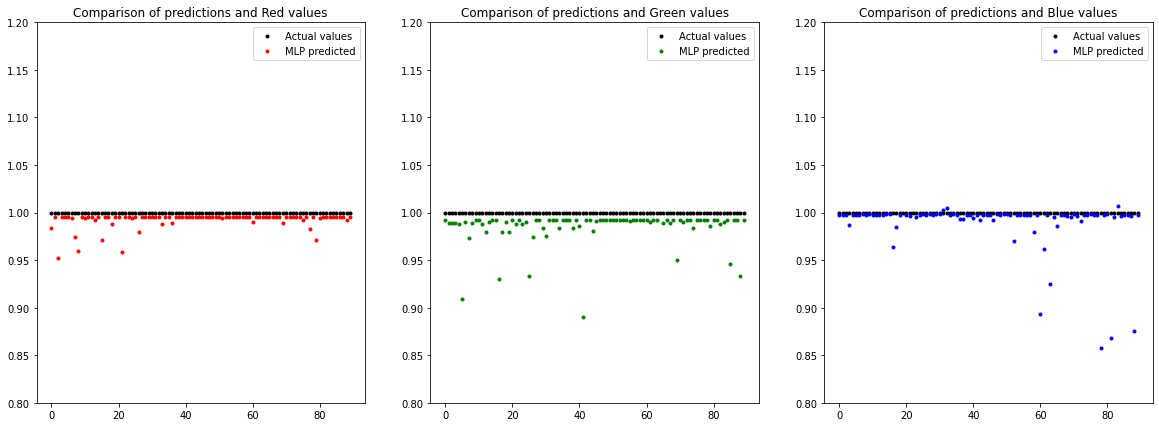

In [ ]:
from numpy.linalg import norm

# Graph the predictions against the actual values
plt.clf()
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
plt.title('Comparison of predictions and Red values')
plt.plot(np.arange(90),np.ones(90), 'k.', label='Actual values')
plt.plot(np.arange(90),norm(y_pred_prob[0:90],axis = 1), 'r.', label='MLP predicted')
plt.ylim(0.8, 1.2)
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Comparison of predictions and Green values')
plt.plot(np.arange(90),np.ones(90), 'k.', label='Actual values')
plt.plot(np.arange(90),norm(y_pred_prob[90:180],axis = 1), 'g.', label= 'MLP predicted')
plt.ylim(0.8, 1.2)
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Comparison of predictions and Blue values')
plt.plot(np.arange(90),np.ones(90), 'k.', label='Actual values')
plt.plot(np.arange(90),norm(y_pred_prob[180:270],axis = 1), 'b.', label='MLP predicted')

plt.ylim(0.8, 1.2)
plt.legend()
plt.show()


Em seguida, construi a rede neural usando a biblioteca do Tensor Flow com a API do Keras. De diferente, inseri 3 neurônios na camada escondida

In [ ]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.Sequential()

model = keras.Sequential([
        keras.layers.Dense( 3, activation='softmax')
])

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

#Train the model
history = model.fit(X_train_scaled, Y_train, epochs=500, batch_size=10)


Plotei o gráfico da perda nos treinos e do MSE

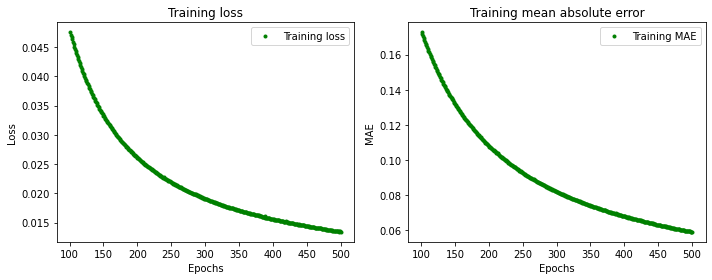

In [ ]:
import matplotlib.pyplot as plt

# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']


epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']


plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.title('Training mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Nessa parte, plotei o gráfico das respostas de cada cor. Percebemos que a primeira rede neural teve resultados melhores.

<Figure size 432x288 with 0 Axes>

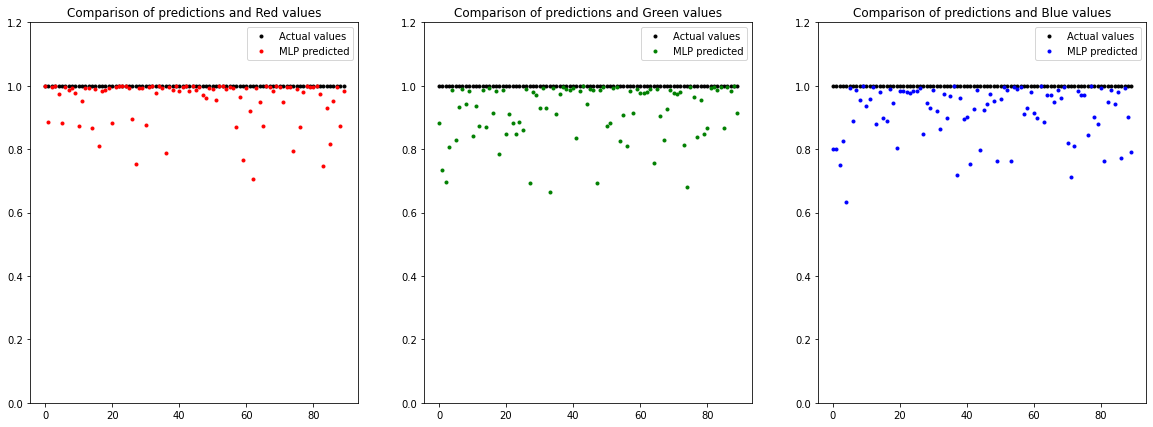

In [ ]:
from numpy.linalg import norm

# Make predictions based on our test dataset
Y_test_pred = model.predict(X_test_scaled)

# Graph the predictions against the actual values
plt.clf()
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
plt.title('Comparison of predictions and Red values')
plt.plot(np.arange(90),np.ones(90), 'k.', label='Actual values')
plt.plot(np.arange(90),norm(Y_test_pred[0:90],axis = 1), 'r.', label='MLP predicted')
plt.ylim(0, 1.2)
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Comparison of predictions and Green values')
plt.plot(np.arange(90),np.ones(90), 'k.', label='Actual values')
plt.plot(np.arange(90),norm(Y_test_pred[90:180],axis = 1), 'g.', label= 'MLP predicted')
plt.ylim(0, 1.2)
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Comparison of predictions and Blue values')
plt.plot(np.arange(90),np.ones(90), 'k.', label='Actual values')
plt.plot(np.arange(90),norm(Y_test_pred[180:270],axis = 1), 'b.', label='MLP predicted')

plt.ylim(0, 1.2)
plt.legend()
plt.show()


Aqui eu tentei desenhar e 3D. Vemos os dados normalizados a esquerda centralizados em 0 e a esquerda as respostas da rede.

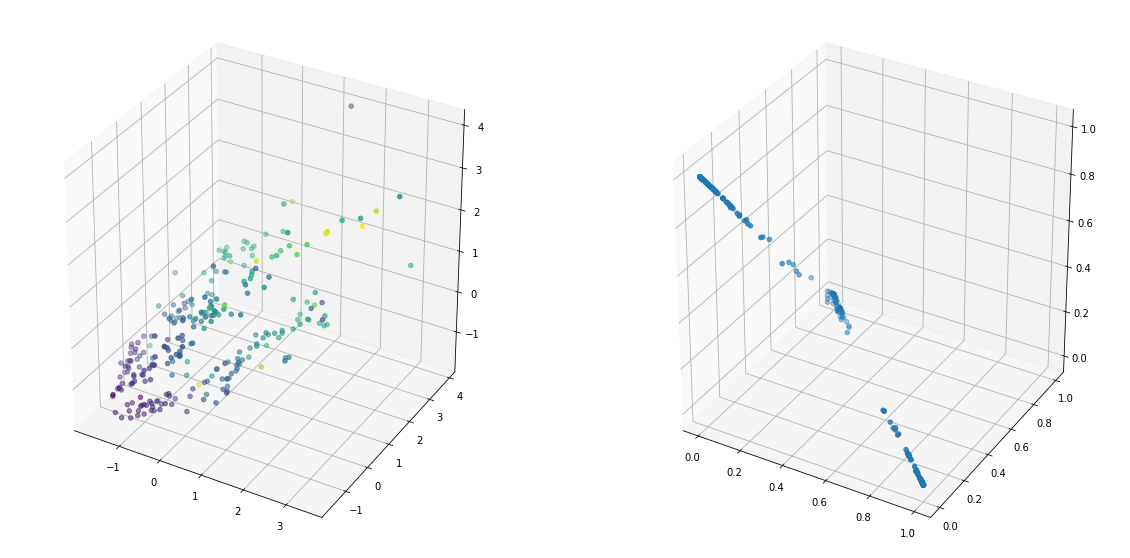

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X_test_scaled[:,1],X_test_scaled[:,2], X_test_scaled[:,3], c=X_test_scaled[:,0])
ax = fig.add_subplot(1, 2, 2,  projection='3d')
ax.scatter(Y_test_pred[:,0],Y_test_pred[:,1], Y_test_pred[:,2])


Aqui temos a acurácia da segunda Rede, porém tomando aproximando todas as probabilidades maiores que 0.5

In [ ]:

print('Accuracy = %.3f'% accuracy_score(Y_test,Y_test_pred>0.5))
print('MSE = %.3f'% mean_squared_error(Y_test, Y_test_pred))


Accuracy = 0.993
MSE = 0.012


Por fim, defino os parâmetros da primeira rede para poder criar uma função que será inserida no arduino

In [ ]:
w_ih   = clf.coefs_[0]
bias_h = clf.intercepts_[0]
w_ho   = clf.coefs_[1]
bias_o = clf.intercepts_[1]


Definição da função de ativação

In [ ]:
def func_ativ(sum):
  return 1/(1+np.exp(-sum))

Nessa parte, eu construi matematicamente a rede neural com os pesos e os bias para testar a acurácia e MSE estão os mesmos

In [ ]:
hid_layer_output = func_ativ(X_test_scaled @ w_ih + bias_h)

In [ ]:
nn_mat = func_ativ(hid_layer_output @ w_ho + bias_o)

In [ ]:
print('Accuracy = %.3f'% accuracy_score(Y_test,nn_mat> 0.9))
print('MSE = %.3f'% mean_squared_error(Y_test, nn_mat> 0.9))


Accuracy = 0.981
MSE = 0.007


Nesse final, defini a função rede neural que será trasnportada para o Arduino. Assim, pelo menos em Python, ela está pronta para receber a leitura do sensor e definir se é vermelho, verde ou azul


In [ ]:
def NeuralNetwork(values):
  values_scaled = (values - mean_dataset)/stdev_dataset
  sum_iw = values_scaled @ w_ih
  output_hl = func_ativ(sum_iw + bias_h)
  sum_ohw = output_hl @ w_ho
  idx_color = np.argmax(func_ativ(sum_ohw+bias_o))
  color = np.array(['Red','Blue','Green'])
  return  print(color[idx_color])


Teste da função

In [ ]:
NeuralNetwork( dataset[455])

Green


Isso é tudo por enquanto, estamos na fase de testar a rede no arduino. Quando tivermos resultados, continuarei esse notebook.